In [146]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import gsw                                  # This is the Gibbs SeaWater toolbox

plt.rcParams['axes.labelsize'] = 16

In [180]:
def read_csv(file):
    
    ctd = pd.read_csv(file, skiprows=28)
    with open(file) as f:
        lines = f.readlines()
    
    latitude = float(lines[9].split(',')[1])
    longitude = float(lines[10].split(',')[1])
    f.close()
    
    if longitude<-140.6:
        loc = 'sitk'
    elif longitude<-140.56:
        loc = 'tria'
    elif np.sqrt((latitude-59.73)**2+(longitude+140.53)**2) < .05:
        loc = 'bkdr'
    elif np.sqrt((latitude-59.80)**2+(longitude+140.15)**2) < .2:
        loc = 'mala'
    else:
        print('location not found ' + str(latitude) + ' ' + str(longitude))
        loc = ''
    
    SP = ctd['Salinity (Practical Salinity Scale)'].to_numpy()
    p = ctd['Pressure (Decibar)'].to_numpy()
    Temp = ctd['Temperature (Celsius)'].to_numpy()
    
    # use the Gibbs Seawater Toolbox to calculate Conservative Temperature and Absolute Salinity
    # this is probably not really necessary; one could likely just proceed with Practical Salinity and Temperature
    
    SA = gsw.SA_from_SP(SP,p,-140.8,59.6)
    CT = gsw.CT_from_t(SA,Temp,p)
    
    cast = {'Latitude':latitude, 'Longitude':longitude, 'Temp':Temp, 'CT':CT, 'SA':SA,
            'PSU':SP, 'Depth':ctd['Depth (Meter)'].to_numpy(),
           'loc':loc}
    
    
    return cast

In [181]:
files = !ls *.csv
casts = []
for file in files:
    casts.append(read_csv(file))

# Define colors for plotting
colors = {'mala':'k','sitk':'b','tria':'r','bkdr':'g'}



location not found 59.8425928 -139.0891897


In [215]:
def plot_TS(casts, sites):
    
    plt.figure(figsize=(12,9))
    
    for loc in sites:
        
        # filter for all the profiles at a given site
        
        loc_filt=list(filter(lambda site: site['loc'] == loc, casts))
        
        SA = np.array([])
        CT = np.array([])
        Depth = np.array([])
        
        for profile in loc_filt:
            SA = np.append(SA,profile['SA'])
            CT = np.append(CT,profile['CT'])
            Depth = np.append(Depth,profile['Depth'])
            
        plt.scatter(SA, CT, 10, Depth)
            
    cb = plt.colorbar()
    cb.set_label(label='Depth', fontsize=16)
    cb.ax.tick_params(labelsize=16)
    
    plt.ylabel('Temperature ($^oC$)', fontsize=16)
    plt.xlabel('Salinity', fontsize=16)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16) 
    
    # plot isopycnals

    # reference pressure
    pref = 0

    SAmin, SAmax = plt.xlim()
    CTmin, CTmax = plt.ylim()

    tempL=np.linspace(CTmin,CTmax,156)
    salL=np.linspace(SAmin,SAmax,156)

    Tg, Sg = np.meshgrid(tempL,salL)
    sigma_theta = gsw.rho(Sg, Tg,pref)-1000

    cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
    cl=plt.clabel(cs,fontsize=18,inline=False,fmt='%.1f')
    

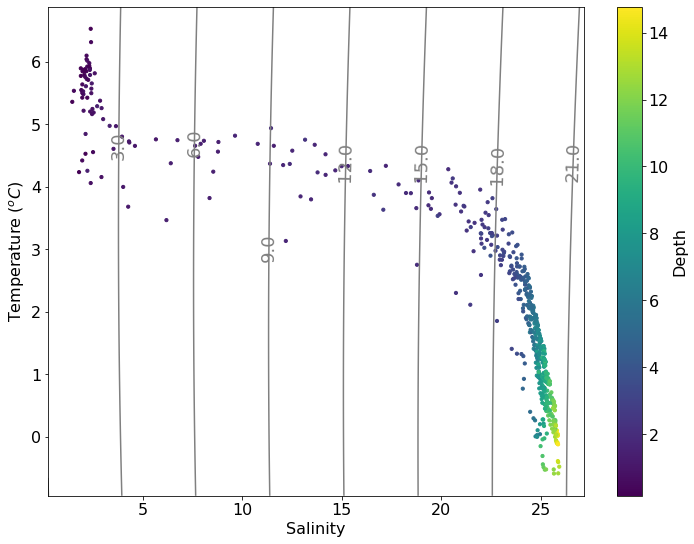

In [219]:
plot_TS(casts,['sitk'])

In [175]:
def plot_profiles(casts,sites):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,9), sharey=True)
        
    leg_line = []
    
    for loc in sites:
        
        loc_filt=list(filter(lambda site: site['loc'] == loc, casts))
        
        for profile in loc_filt:
            ax1.plot(profile['Temp'], -profile['Depth'], colors[loc])
            ax2.plot(profile['PSU'], -profile['Depth'], colors[loc])
            
        
        leg_line.append(mlines.Line2D([], [], color=colors[loc], label=loc))
    
    ax1.set(xlabel='Temperature ($^oC$)', ylabel='Depth (m)')
   
    ax2.set(xlabel='Salinity (PSU)')
    plt.legend(handles=leg_line, fontsize=16)

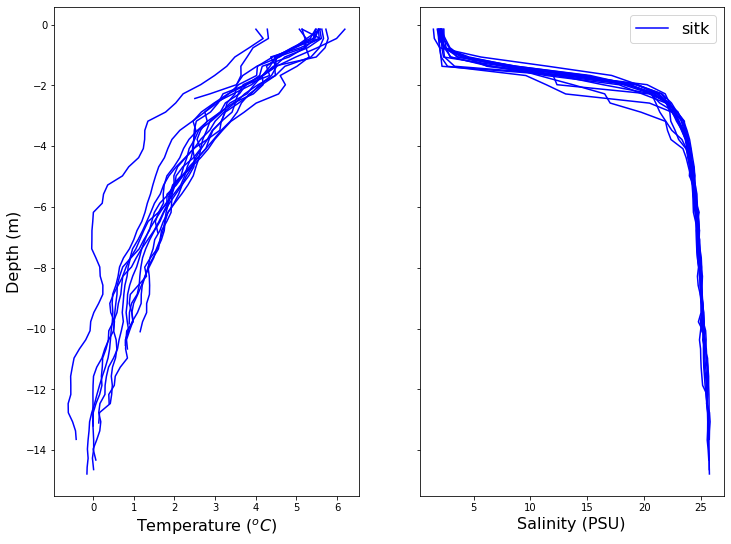

In [198]:
plot_profiles(casts,['sitk'])#,'mala','bkdr','tria'])

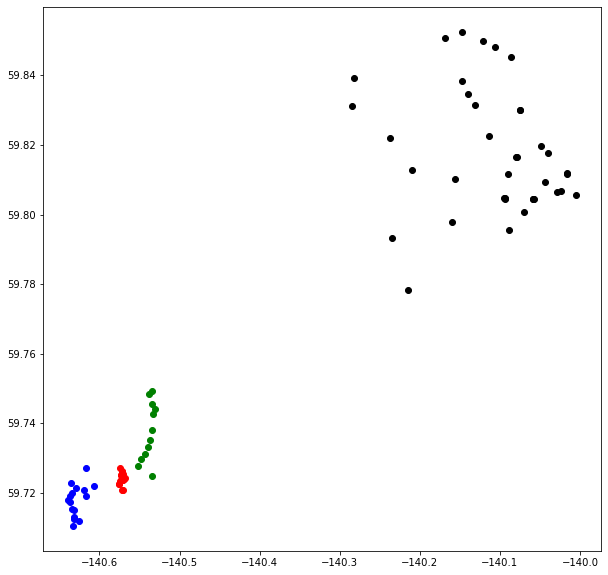

In [190]:
# just making sure they are all located correctly ...

plt.figure(figsize=(10,10))

sites=['mala','bkdr','sitk','tria']
for loc in sites:
    loc_filt=list(filter(lambda site: site['loc'] == loc, casts))
    for profile in loc_filt:
        plt.plot(profile['Longitude'], profile['Latitude'], marker='o', color=colors[loc])

In [226]:

print(gsw.__version__)

3.4.0
